In [6]:
import numpy
import plotly.graph_objects as go
import quadpy
import scipy.sparse

In [7]:
def f(x):
    a = -0.5
    return a*(x-0)*(x-1)*(x-2)*(x-3)*(x-4)

In [8]:
x = numpy.linspace(0, 4, 100)
y = f(x)

In [9]:
def plot(xs, ys, filename):
    fig = go.Figure(data=[
        go.Scatter(x=x, y=y, line=dict(width=5), marker=dict(size=10))
        for x, y in zip(xs, ys)])

    fig.update_layout(
        # title=dict(text=f"L2 Projection Error (u(x,y) = {u_str})", x=0.5),
        width=600,
        height=400,
        xaxis=dict(ticks="inside"),
        yaxis=dict(ticks="inside"),
        template="simple_white",
        font=dict(size=18),
        showlegend=False,
        # legend=dict(orientation="v", yanchor="top", y=1.15,
        #             xanchor="right", x=0.99, bgcolor='rgba(0,0,0,0)', font_size=18),
        margin=dict(l=10, r=10, t=60, b=10))

    fig.write_image(filename)
    fig.show()

plot([x], [y], "f.pdf")

In [10]:
xhat = numpy.linspace(0, 4, 10)
yhat = f(xhat)

In [11]:
plot([x, xhat], [y, yhat], "sample.pdf")

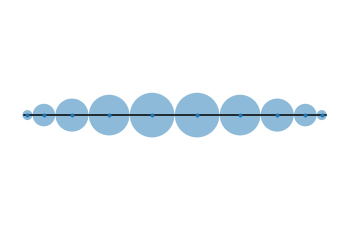

array([-0.97390653, -0.86506337, -0.67940957, -0.43339539, -0.14887434,
        0.14887434,  0.43339539,  0.67940957,  0.86506337,  0.97390653])

In [12]:
quadrature = quadpy.c1.gauss_legendre(10)
quadrature.show()
quadrature.points

In [13]:
P1_1D_bases = [
    lambda x: 1-x, lambda x: x
]

def P1_1D_gmapping(x, p0, p1):
    return (1 - x) * p0 + x * p1

def grad_P1_1D_gmapping(x, p0, p1):
    return abs(p1 - p0)

In [14]:
def build_mass_matrix(xhat):
    M = scipy.sparse.lil_matrix((xhat.size, xhat.size))
    for ei, element in enumerate(zip(xhat[:-1], xhat[1:])):
        for i, phi_i in zip([ei, ei+1], P1_1D_bases):
            for j, phi_j in zip([ei, ei+1], P1_1D_bases):
                for w, x in zip(quadrature.weights, quadrature.points):
                    x = x / 2 + 0.5
                    M[i, j] += w/2 * phi_i(x) * phi_j(x) * grad_P1_1D_gmapping(x, *element)
    return M.tocsc()

In [15]:
def build_rhs(xhat):
    b = numpy.zeros(xhat.size)
    for ei, element in enumerate(zip(xhat[:-1], xhat[1:])):
        for i, phi_i in zip([ei, ei+1], P1_1D_bases):
            for w, x in zip(quadrature.weights, quadrature.points):
                x = x / 2 + 0.5
                b[i] += w/2 * f(P1_1D_gmapping(x, *element)) * phi_i(x) * grad_P1_1D_gmapping(x, *element)
    return b

In [16]:
# y_L2 = yhat.copy()
# y_L2[1:-1] = numpy.linalg.solve(build_mass_matrix(xhat).A[1:-1, 1:-1], build_rhs(xhat)[1:-1])
y_L2 = numpy.linalg.solve(build_mass_matrix(xhat).A, build_rhs(xhat))
plot([x, xhat], [y, y_L2], "L2.pdf")

In [17]:
x_smooth = numpy.array([0, 0.2424242424, 0.4444444444, 1.25252525252, 1.61616161612, 2.38383838383, 2.7878787878, 3.515151515, 3.7575757575, 4])
y_smooth = f(x_smooth)
plot([x, x_smooth], [y, y_smooth], "smooth.pdf")

In [18]:
y_smooth_L2 = numpy.linalg.solve(build_mass_matrix(x_smooth).A, build_rhs(x_smooth))
plot([x, x_smooth], [y, y_smooth_L2], "smooth_L2.pdf")

In [19]:
x_split = numpy.array([0, 0.2424242424, 0.4444444444, 1, 1.25252525252, 1.61616161612, 2, 2.38383838383, 2.7878787878, 3, 3.515151515, 3.7575757575, 4])
y_split = f(x_split)
plot([x, x_split], [y, y_split], "split.pdf")

In [20]:
y_split_L2 = numpy.linalg.solve(build_mass_matrix(x_split).A, build_rhs(x_split))
plot([x, x_split], [y, y_split_L2], "split_L2.pdf")